_This notebook contains code and comments from Section 8.3 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

---

## 8.3	Case Study: Income Prediction

El conjunto de datos para adultos del [repositorio de aprendizaje automático UCI](https://archive.ics.uci.edu/ml/datasets/adult) es un conjunto de datos de aprendizaje automático de referencia clásico. La tarea es predecir si un individuo gana más de $50,000 al año. El conjunto de datos consta de XXXX individuos, cada uno representado por 14 características, que son una combinación de variables continuas y categóricas (que se muestran en negrita).

1. _edad_: continuo.
2. **clase de trabajo**: privado, autónomo, no incluido, autónomo, incluido, gobierno federal, gobierno local, gobierno estatal, sin sueldo, nunca trabajó.
3. _fnlwgt_: continuo.
4. **educación**: Licenciatura, Algo de universidad, 11.°, Graduado de HS, Escuela profesional, Assoc-acdm, Assoc-voc, 9.°, 7.° a 8.°, 12.°, Maestría, 1.° a 4.°, 10.°, Doctorado, 5.° a 6.°, Preescolar.
5. _educación-num_: continuo.
6. **estado civil**: Casado-civ-cónyuge, Divorciado, Nunca casado, Separado, Viudo, Casado-cónyuge-ausente, Casado-AF-cónyuge.
7. **ocupación**: soporte técnico, reparación artesanal, otros servicios, ventas, gerente ejecutivo, especialidad profesional, manipuladores-limpiadores, inspección de máquinas, administración administrativa, agricultura-pesca, transporte-mudanza, servicio privado, servicio de protección, fuerzas armadas.
8. **relación**: esposa, hijo propio, esposo, fuera de la familia, otro pariente, soltero.
9. **raza**: Blanco, Asiático-Pac-Isleño, Amer-Indio-Esquimal, Otro, Negro.
10. **sexo**: Mujer, Hombre.
11. _ganancia de capital_: continuo.
12. _pérdida de capital_: continuo.
13. _horas-por-semana_: continuo.
14. **país nativo**: Estados Unidos, Camboya, Inglaterra, Puerto Rico, Canadá, Alemania, EE. UU. (Guam-USVI-etc), India, Japón, Grecia, Sur, China, Cuba, Irán, Honduras, Filipinas, Italia, Polonia, Jamaica, Vietnam, México, Portugal, Irlanda, Francia, República Dominicana, Laos, Ecuador, Taiwán, Haití, Colombia, Hungría, Guatemala, Nicaragua, Escocia, Tailandia, Yugoslavia, El-Salvador, Trinidad y Tobago, Perú, Hong , Holanda-Países Bajos.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('./data/ch08/adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


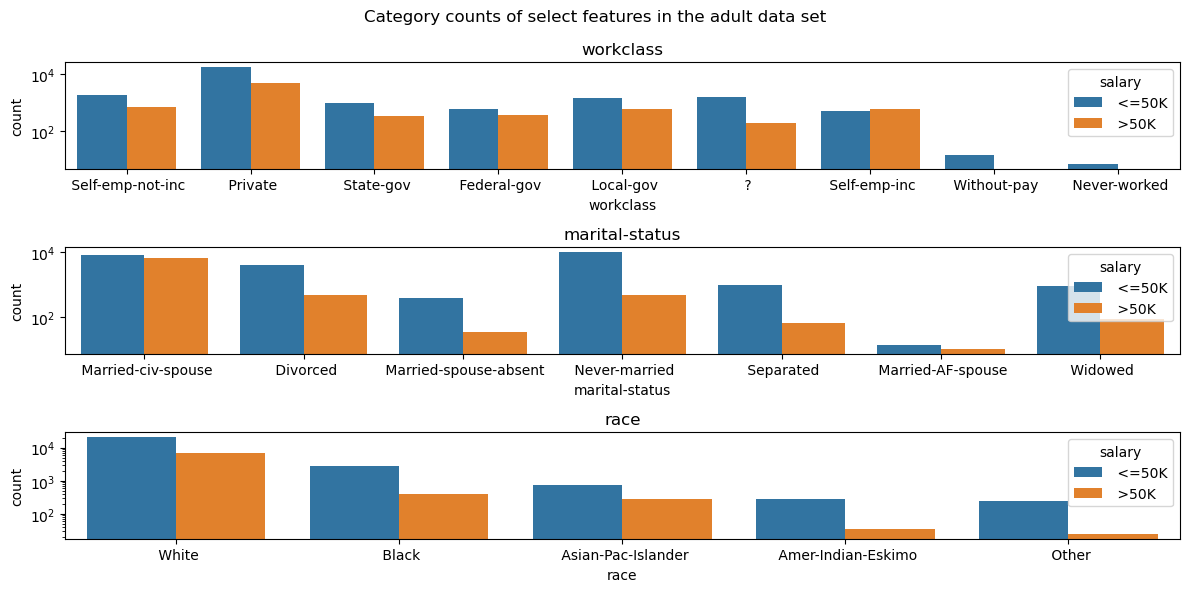

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=((12, 6)))
fig.suptitle('Category counts of select features in the adult data set')
sns.countplot(x='workclass', hue='salary', data=df, ax=ax[0])
ax[0].set(yscale='log')
ax[0].set_title('workclass')
sns.countplot(x='marital-status', hue='salary', data=df, ax=ax[1])
ax[1].set(yscale='log')
ax[1].set_title('marital-status')
sns.countplot(x='race', hue='salary', data=df, ax=ax[2])
ax[2].set(yscale='log')
ax[2].set_title('race')

fig.tight_layout()
# plt.savefig('./figures/CH08_F13_Kunapuli.png', format='png', dpi=300, bbox_inches='tight')
# plt.savefig('./figures/CH08_F13_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight')

La siguiente lista describe cómo preparar los datos. En particular, usamos ``sklearn.preprocessing.LabelEncoder`` para convertir las etiquetas objetivo de cadena (<=50k, >50k) a numérico (0/1). ``LabelEncoder`` es idéntico a ``OrdinalEncoder``, excepto que está específicamente diseñado para trabajar con datos 1D (objetivos).

**Apartado 8.5**. Preparar los datos del censo de adultos

In [4]:
X, y = df.drop('salary', axis=1), df['salary']  # Split the data into features and targets

from sklearn.preprocessing import LabelEncoder
y = LabelEncoder().fit_transform(y)

from sklearn.model_selection import train_test_split
Xtrn, Xtst, ytrn, ytst = train_test_split(X, y, test_size=0.2)

features = X.columns
cat_features = ['workclass', 'education', 'marital-status', 'occupation', 
                'relationship', 'race', 'sex', 'native-country']
cont_features = features.drop(cat_features).tolist()

Aquí vemos que la distribución positiva-negativa es del 24,1 % al 75,9 %, en lugar del 50 % al 50 %. Esto significa que las métricas de evaluación, como la precisión, pueden distorsionar involuntariamente nuestra visión del rendimiento del modelo, ya que asumen un conjunto de datos equilibrado.

In [5]:
import numpy as np
n_pos, n_neg = np.sum(y > 0)/len(y), np.sum(y <= 0)/len(y)
print(n_pos, n_neg)

0.24081695331695332 0.7591830466830467


---
definimos una función de preprocesamiento que se puede reutilizar con diferentes tipos de codificadores de categoría. Esta función tiene dos canalizaciones de preprocesamiento, una que se aplicará solo a entidades continuas y la otra a entidades categóricas. Las características continuas se preprocesan utilizando ``StandardScaler``, que normaliza cada columna de características para que tenga una media cero y una desviación estándar de la unidad.

Además, ambos pipelines tienen un ``SimpleImputer``, para imputar valores perdidos. Los valores continuos que faltan se imputan con su valor de característica mediana correspondiente, mientras que las características categóricas que faltan se imputan como una nueva categoría llamada "falta" antes de la codificación.

Por ejemplo, la clase de trabajo de características tiene valores faltantes (indicados por '?', que se tratan como una categoría separada para fines de modelado.


**Apartado 8.6.** Tuberías de preprocesamiento (Pipelines)

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import category_encoders as ce
            
def create_preprocessor(encoder):
    preprocess_continuous = Pipeline(steps=[('impute_missing', SimpleImputer(strategy='median')),
                                            ('normalize', StandardScaler())])
    preprocess_categorical = Pipeline(steps=[('impute_missing', SimpleImputer(strategy='constant', fill_value='missing')),
                                             ('encode', encoder())])
    transformations = ColumnTransformer(transformers=[('continuous', preprocess_continuous, cont_features),
                                                      ('categorical', preprocess_categorical, cat_features)])
    
    return transformations

---
Definimos una función para entrenar y evaluar diferentes tipos de conjuntos, combinándolos con diferentes tipos de codificación de categorías. Esto nos permitirá crear diferentes modelos de conjuntos combinando diferentes paquetes de aprendizaje de conjuntos con diferentes tipos de codificadores de categorías.

La siguiente función nos permite pasar un ``conjunto`` así como una cuadrícula de ``parámetros`` de conjunto para la selección de parámetros de conjunto. Utiliza validación cruzada n-fold combinada con búsqueda aleatoria para identificar los mejores parámetros de conjunto antes de entrenar un modelo final con estos mejores parámetros.

Una vez entrenada, la función evalúa el rendimiento del modelo final en el conjunto de prueba utilizando tres métricas: precisión, precisión equilibrada y puntaje F1. La precisión equilibrada y la puntuación F1 son métricas especialmente útiles cuando el conjunto de datos está desequilibrado, ya que tienen en cuenta el desequilibrio de las etiquetas al ponderar el rendimiento del modelo en cada clase en función de la frecuencia con la que aparecen en las etiquetas.

**Apartado 8.7.** Entrenamiento y evaluación de combinaciones de codificadores y ensambles

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score

def train_and_evaluate_models(ensemble, parameters, n_iter=25, cv=5):
    results = pd.DataFrame()
    
    for encoder in [ce.OneHotEncoder, ce.OrdinalEncoder, ce.TargetEncoder]:
        preprocess_pipeline = create_preprocessor(encoder)
        print('Encoder = {0}, Ensemble = {1}'.format(encoder, type(ensemble)))

        model = Pipeline(steps=[('preprocess', preprocess_pipeline),
                                ('crossvalidate', RandomizedSearchCV(ensemble, parameters, 
                                                                     n_iter=n_iter, cv=cv, 
                                                                     refit=True, verbose=2))])
        model.fit(Xtrn, ytrn)
        
        ypred_trn = model.predict(Xtrn)
        ypred_tst = model.predict(Xtst)    

        res = {'Encoder': encoder.__name__,
               'Ensemble': ensemble.__class__.__name__, 
               'Train Acc': accuracy_score(ytrn, ypred_trn),
               'Train B Acc': balanced_accuracy_score(ytrn, ypred_trn), 
               'Train F1': f1_score(ytrn, ypred_trn), 
               'Test Acc': accuracy_score(ytst, ypred_tst),
               'Test B Acc': balanced_accuracy_score(ytst, ypred_tst),
               'Test F1': f1_score(ytst, ypred_tst)}
        
        results = pd.concat([results, pd.DataFrame.from_dict([res])], ignore_index=True)
    
    return results

---
### Bosque aleatorio
La siguiente lista entrena y evalúa la mejor combinación de codificación categórica (un objetivo activo, ordinal y codicioso) y bosque aleatorio.

**Apartado 8.8.** Codificación de categoría seguida de ensamblaje con bosque aleatorio

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

ensemble = RandomForestClassifier(n_jobs=-1)
parameters = {'n_estimators': [25, 50, 100, 200],
              'max_depth': [3, 5, 7, 10],
              'max_features': [0.2, 0.4, 0.6, 0.8]}


rf_results = train_and_evaluate_models(ensemble, parameters, n_iter=25, cv=5)

Encoder = <class 'category_encoders.one_hot.OneHotEncoder'>, Ensemble = <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .....max_depth=7, max_features=0.4, n_estimators=25; total time=   4.2s
[CV] END .....max_depth=7, max_features=0.4, n_estimators=25; total time=   0.4s
[CV] END .....max_depth=7, max_features=0.4, n_estimators=25; total time=   0.4s
[CV] END .....max_depth=7, max_features=0.4, n_estimators=25; total time=   0.5s
[CV] END .....max_depth=7, max_features=0.4, n_estimators=25; total time=   0.6s
[CV] END ....max_depth=5, max_features=0.8, n_estimators=100; total time=   2.3s
[CV] END ....max_depth=5, max_features=0.8, n_estimators=100; total time=   2.5s
[CV] END ....max_depth=5, max_features=0.8, n_estimators=100; total time=   2.2s
[CV] END ....max_depth=5, max_features=0.8, n_estimators=100; total time=   2.4s
[CV] END ....max_depth=5, max_features=0.8, n_estimators=100; total time=   2.3

In [11]:
rf_results

,Encoder,Ensemble,Train Acc,Train B Acc,Train F1,Test Acc,Test B Acc,Test F1
0,OneHotEncoder,RandomForestClassifier,0.876574,0.789738,0.708760,0.865786,0.767842,0.673149
1,OrdinalEncoder,RandomForestClassifier,0.869779,0.775781,0.687834,0.862408,0.761407,0.662904
2,TargetEncoder,RandomForestClassifier,0.880183,0.797208,0.719662,0.868243,0.777226,0.685484


---
### LightGBM
A continuación, repetimos este procedimiento de entrenamiento y evaluación con LightGBM, donde entrenamos un conjunto con 200 árboles. Se seleccionarán varios otros hiperparámetros de conjunto utilizando una validación cruzada de 5 veces: profundidad máxima del árbol, tasa de aprendizaje, fracción de embolsado y parámetros de regularización.

**Apartado 8.9.** Codificación de categorías seguida de ensamblaje con LightGBM

In [12]:
from lightgbm import LGBMClassifier

ensemble = LGBMClassifier(n_estimators=200, n_jobs=-1)
parameters = {'max_depth': np.arange(3, 10, step=1), 
              'learning_rate': 2.**np.arange(-8., 2., step=2),
              'bagging_fraction': [0.4, 0.5, 0.6, 0.7, 0.8],
              'lambda_l1': [0, 0.01, 0.1, 1, 10],
              'lambda_l2': [0, 0.01, 0.1, 1e-1, 1, 10]}

lgbm_results = train_and_evaluate_models(ensemble, parameters, n_iter=50, cv=5)

Encoder = <class 'category_encoders.one_hot.OneHotEncoder'>, Ensemble = <class 'lightgbm.sklearn.LGBMClassifier'>
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[CV] END bagging_fraction=0.7, lambda_l1=0, lambda_l2=0.1, learning_rate=1.0, max_depth=8; total time=   0.2s
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[CV] END bagging_fraction=0.7, lambda_l1=0, lambda_l2=0.1, learning_rate=1

In [13]:
lgbm_results

,Encoder,Ensemble,Train Acc,Train B Acc,Train F1,Test Acc,Test B Acc,Test F1
0,OneHotEncoder,LGBMClassifier,0.885557,0.816619,0.742551,0.875768,0.795041,0.710555
1,OrdinalEncoder,LGBMClassifier,0.890126,0.822610,0.752636,0.874693,0.793447,0.707946
2,TargetEncoder,LGBMClassifier,0.885634,0.820082,0.745450,0.876536,0.798431,0.714489


---
### XGBoost
A continuación, repetimos este procedimiento de entrenamiento y evaluación también con XGBoost, donde nuevamente entrenamos un conjunto de 200 árboles.

**Apartado 8.10.** Codificación de categorías seguida de ensamblaje con XGBoost

In [14]:
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

ensemble = XGBClassifier(eval_metric='logloss', n_estimators=200, n_jobs=-1)
parameters = {'max_depth': np.arange(3, 10, step=1), 
              'learning_rate': 2.**np.arange(-8., 2., step=2),
              'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8],
              'reg_alpha': [0, 0.01, 0.1, 1, 10],
              'reg_lambda': [0, 0.01, 0.1, 1e-1, 1, 10]}

xgb_results = train_and_evaluate_models(ensemble, parameters, n_iter=50, cv=5)


Encoder = <class 'category_encoders.one_hot.OneHotEncoder'>, Ensemble = <class 'xgboost.sklearn.XGBClassifier'>
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.8, learning_rate=0.0625, max_depth=3, reg_alpha=1, reg_lambda=0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.0625, max_depth=3, reg_alpha=1, reg_lambda=0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.0625, max_depth=3, reg_alpha=1, reg_lambda=0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.0625, max_depth=3, reg_alpha=1, reg_lambda=0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.0625, max_depth=3, reg_alpha=1, reg_lambda=0; total time=   1.1s
[CV] END colsample_bytree=0.4, learning_rate=0.25, max_depth=7, reg_alpha=0.01, reg_lambda=10; total time=   1.4s
[CV] END colsample_bytree=0.4, learning_rate=0.25, max_depth=7, reg_alpha=0.01, reg_lambda=10; total time=   1.5s
[CV] END colsample_bytree=0.4, learnin

In [15]:
xgb_results

,Encoder,Ensemble,Train Acc,Train B Acc,Train F1,Test Acc,Test B Acc,Test F1
0,OneHotEncoder,XGBClassifier,0.893773,0.827884,0.761074,0.875461,0.795061,0.710254
1,OrdinalEncoder,XGBClassifier,0.892621,0.825500,0.757856,0.876382,0.793445,0.709701
2,TargetEncoder,XGBClassifier,0.885557,0.817486,0.743261,0.877150,0.800388,0.716914


---
Finalmente, exploramos el rendimiento de CatBoost en este conjunto de datos. A diferencia de los enfoques anteriores, no usaremos el paquete ``category_encoders``. Esto se debe a que CatBoost utiliza estadísticas de destino ordenadas junto con impulso ordenado.

Esto significa que, siempre que identifique claramente las características categóricas que necesitan codificación con estadísticas de destino ordenadas, CatBoost se encargará del resto y ¡no es necesario que incorporemos ningún procesamiento previo adicional!

**Apartado 8.11.** Codificación de destino ordenado y refuerzo ordenado con CatBoost

In [16]:
from catboost import CatBoostClassifier

ensemble = CatBoostClassifier(cat_features=cat_features)
parameters = {'iterations': [25, 50, 100, 200],
              'depth': np.arange(3, 10, step=1), 
              'learning_rate': 2.**np.arange(-5., 0., step=1),
              'l2_leaf_reg': [0, 0.01, 0.1, 1e-1, 1, 10]}

search = ensemble.randomized_search(parameters, Xtrn, ytrn, n_iter=50, cv=5, refit=True, verbose=False)
ypred_trn = ensemble.predict(Xtrn)
ypred_tst = ensemble.predict(Xtst)    

res = {'Encoder': '',
       'Ensemble': ensemble.__class__.__name__, 
       'Train Acc': accuracy_score(ytrn, ypred_trn),
       'Train B Acc': balanced_accuracy_score(ytrn, ypred_trn), 
       'Train F1': f1_score(ytrn, ypred_trn), 
       'Test Acc': accuracy_score(ytst, ypred_tst),
       'Test B Acc': balanced_accuracy_score(ytst, ypred_tst),
       'Test F1': f1_score(ytst, ypred_tst)}
cat_results = pd.DataFrame()
# cat_results = cat_results.append(res, ignore_index=True)
cat_results = pd.concat([cat_results, 
                         pd.DataFrame.from_dict([res])], ignore_index=True)

0:	learn: 0.5055057	test: 0.5105609	best: 0.5105609 (0)	total: 179ms	remaining: 4.29s
1:	learn: 0.4261505	test: 0.4356420	best: 0.4356420 (1)	total: 208ms	remaining: 2.39s
2:	learn: 0.3965527	test: 0.4069688	best: 0.4069688 (2)	total: 237ms	remaining: 1.74s
3:	learn: 0.3692137	test: 0.3822765	best: 0.3822765 (3)	total: 263ms	remaining: 1.38s
4:	learn: 0.3514583	test: 0.3663068	best: 0.3663068 (4)	total: 292ms	remaining: 1.17s
5:	learn: 0.3422910	test: 0.3579657	best: 0.3579657 (5)	total: 322ms	remaining: 1.02s
6:	learn: 0.3330933	test: 0.3496929	best: 0.3496929 (6)	total: 353ms	remaining: 907ms
7:	learn: 0.3280227	test: 0.3455446	best: 0.3455446 (7)	total: 384ms	remaining: 816ms
8:	learn: 0.3254531	test: 0.3426593	best: 0.3426593 (8)	total: 415ms	remaining: 737ms
9:	learn: 0.3222056	test: 0.3399651	best: 0.3399651 (9)	total: 443ms	remaining: 664ms
10:	learn: 0.3189030	test: 0.3382994	best: 0.3382994 (10)	total: 480ms	remaining: 610ms
11:	learn: 0.3159279	test: 0.3359764	best: 0.3359764

In [22]:
cat_results

,Encoder,Ensemble,Test Acc,Test B Acc,Test F1,Train Acc,Train B Acc,Train F1
0,,CatBoostClassifier,0.870086,0.796216,0.707671,0.887976,0.819709,0.747403


Ahora, pongamos los resultados de todos los enfoques uno al lado del otro; en la figura a continuación, observamos cómo se desempeñó cada enfoque con respecto a la precisión equilibrada evaluada en el conjunto de prueba. Al analizar estos resultados, tenga en cuenta, siempre, que ningún método funciona mejor todo el tiempo. Sin embargo, cuando CatBoost disfruta de dos beneficios clave:
- permite un enfoque consolidado para la codificación y el manejo de características categóricas, a diferencia de otros enfoques de conjunto que necesariamente utilizan un enfoque de codificación + conjunto de dos pasos, y
- por diseño, mitiga la fuga de datos y objetivos y los problemas de cambio de distribución, que a menudo requieren más atención con otros enfoques de ensamblaje.

In [17]:
results = pd.concat([rf_results, lgbm_results, xgb_results, cat_results])
results.to_csv('./data/ch08/case-study-results.csv', index=False)

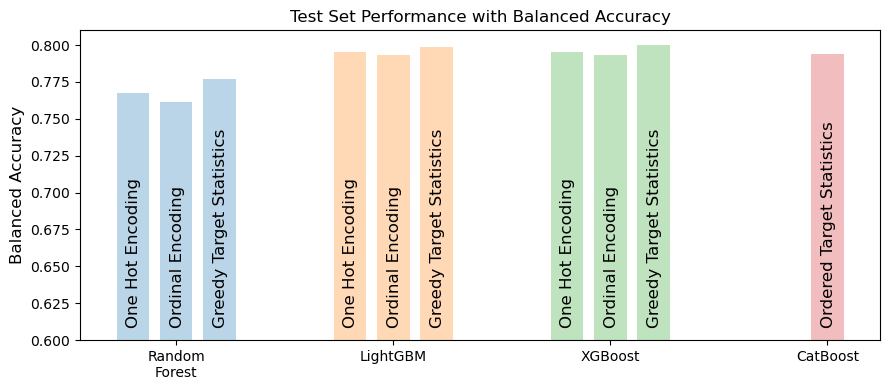

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
results = pd.read_csv('./data/ch08/case-study-results.csv')
results

# groups = {'RandomForestClassifier': ['OneHotEncoder', 'OrdinalEncoder', 'TargetEncoder'],
#           'LGBMClassifier': ['OneHotEncoder', 'OrdinalEncoder', 'TargetEncoder'],
#           'XGBClassifier': ['OneHotEncoder', 'OrdinalEncoder', 'TargetEncoder'],
#           'CatBoostClassifier': []}

groups = {'Random\nForest': [0, 1, 2], 
          'LightGBM': [3, 4, 5], 
          'XGBoost': [6, 7, 8], 
          'CatBoost': 9}    

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
for j, metric in enumerate(['Test B Acc']):
    for i, (methods, group) in enumerate(groups.items()):
        k = results.columns.get_loc(metric)
        yy = results.values[groups[methods], k]
        
        if methods == 'CatBoost':
            xx = i + (np.arange(0, 1) - np.median(np.arange(0, 1))) * 0.2
        else:
            xx = i + (np.arange(0, len(yy)) - np.median(np.arange(0, len(yy)))) * 0.2
        ax.bar(xx, yy, width=0.15, alpha=0.3)
#         
        encs = ['One Hot Encoding', 'Ordinal Encoding', 'Greedy Target Statistics']
        for t in range(len(xx)):
            if len(xx) == 1:
                ax.text(xx[t]-0.03, 0.61, 'Ordered Target Statistics', rotation='vertical', fontsize=12)
            else:
                ax.text(xx[t]-0.03, 0.61, encs[t], rotation='vertical', fontsize=12)
ax.set_xticks(range(4))
ax.set_xticklabels(list(groups.keys()))
ax.set_ylabel('Balanced Accuracy', fontsize=12)
ax.set_title('Test Set Performance with Balanced Accuracy', fontsize=12)
ax.set_ylim(0.6, 0.81)

fig.tight_layout()
# plt.savefig('./figures/CH08_F14_Kunapuli.png', format='png', dpi=300, bbox_inches='tight')
# plt.savefig('./figures/CH08_F14_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [19]:
import pandas as pd
results = pd.read_csv('./data/ch08/case-study-results.csv')

In [20]:
results = results.drop('Encoder', axis=1)
pd.options.display.float_format = '{:,.3}'.format
print(results.to_string(index=False))

              Ensemble  Train Acc  Train B Acc  Train F1  Test Acc  Test B Acc  Test F1
RandomForestClassifier      0.877         0.79     0.709     0.866       0.768    0.673
RandomForestClassifier       0.87        0.776     0.688     0.862       0.761    0.663
RandomForestClassifier       0.88        0.797      0.72     0.868       0.777    0.685
        LGBMClassifier      0.886        0.817     0.743     0.876       0.795    0.711
        LGBMClassifier       0.89        0.823     0.753     0.875       0.793    0.708
        LGBMClassifier      0.886         0.82     0.745     0.877       0.798    0.714
         XGBClassifier      0.894        0.828     0.761     0.875       0.795     0.71
         XGBClassifier      0.893        0.826     0.758     0.876       0.793     0.71
         XGBClassifier      0.886        0.817     0.743     0.877         0.8    0.717
    CatBoostClassifier      0.879        0.807     0.727     0.875       0.794    0.708
